# H-calls4fam_TFDS_rnn


In [1]:
# @title
import datetime
print(datetime.datetime.now())

2024-05-04 12:34:03.086127


Similar to the example we demonstrate in the class, here are some samples of malware call sequences.

Now you need to use RNN to analysis the call sequences.

In [2]:
import os
import pandas as pd
import numpy as np

## tfds Data

In [3]:
# TFDS
name = "calls4fam_0522"

save_dir = "./" + name + "/"

In [4]:
# get data from github

import requests

url = 'https://github.com/hsiaom26/DS4CS-24/raw/main/data/calls4fam_0522_tfds.tgz'

response = requests.get(url)

if response.status_code == 200:
    # Open the file for writing
    with open('calls4fam_0522_tfds.tgz', 'wb') as f:
        # Write the response content to the file
        f.write(response.content)
else:
    print('Error: Failed to download the file')

In [5]:
!tar -zxvf calls4fam_0522_tfds.tgz

./calls4fam_0522/
./calls4fam_0522/2/
./calls4fam_0522/2/626.txt
./calls4fam_0522/2/834.txt
./calls4fam_0522/2/751.txt
./calls4fam_0522/2/866.txt
./calls4fam_0522/2/735.txt
./calls4fam_0522/2/850.txt
./calls4fam_0522/2/808.txt
./calls4fam_0522/2/847.txt
./calls4fam_0522/2/661.txt
./calls4fam_0522/2/809.txt
./calls4fam_0522/2/686.txt
./calls4fam_0522/2/638.txt
./calls4fam_0522/2/774.txt
./calls4fam_0522/2/758.txt
./calls4fam_0522/2/791.txt
./calls4fam_0522/2/631.txt
./calls4fam_0522/2/854.txt
./calls4fam_0522/2/629.txt
./calls4fam_0522/2/616.txt
./calls4fam_0522/2/889.txt
./calls4fam_0522/2/617.txt
./calls4fam_0522/2/902.txt
./calls4fam_0522/2/772.txt
./calls4fam_0522/2/837.txt
./calls4fam_0522/2/623.txt
./calls4fam_0522/2/815.txt
./calls4fam_0522/2/822.txt
./calls4fam_0522/2/648.txt
./calls4fam_0522/2/768.txt
./calls4fam_0522/2/884.txt
./calls4fam_0522/2/694.txt
./calls4fam_0522/2/745.txt
./calls4fam_0522/2/769.txt
./calls4fam_0522/2/839.txt
./calls4fam_0522/2/784.txt
./calls4fam_0522/

In [6]:
!ls -al calls4fam_0522

total 56
drwxr-xr-x 6 root root  4096 Feb 21 04:06 .
drwxr-xr-x 1 root root  4096 May  4 12:48 ..
drwxr-xr-x 2 root root 12288 Feb 21 04:06 0
drwxr-xr-x 2 root root 12288 Feb 21 04:06 1
drwxr-xr-x 2 root root 12288 Feb 21 04:06 2
drwxr-xr-x 2 root root 12288 Feb 21 04:06 5


### Transform to tf.Data by utils.text_dataset_from_directory

In [7]:
import tensorflow as tf
from tensorflow.keras import utils
import tensorflow_datasets as tfds

In [8]:
batch_size = 32
seed = 42

train_dataset = utils.text_dataset_from_directory(
    save_dir, # from unziped dir
    labels = "inferred", # labels are generated from the directory structure
    label_mode = "int", # for sparse_categorical_crossentropy loss
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'training', # or 'validation' to get the val dataset
    )

Found 1208 files belonging to 4 classes.
Using 967 files for training.


In [9]:
val_dataset = utils.text_dataset_from_directory(
    save_dir,
    labels = "inferred",
    label_mode = "int",
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'validation', # <----
    )

Found 1208 files belonging to 4 classes.
Using 241 files for validation.


In [10]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for example, label in train_dataset.take(1): # take 1 batch_size
  for i in range(3): # print first 3
    print('label: ', label[i].numpy())
    print('text: ', example[i].numpy())

In [12]:
# vocab size
vocab_set = set()
separator = ' '

# classes
class_set = set()

In [13]:
for text_batch, label_batch in train_dataset:
  for idx in range(len(text_batch)):
    # text
    line = text_batch.numpy()[idx]
    line = line.decode("utf-8")
    tokens = line.split(separator)
    for token in tokens:
      vocab_set.add(token)

    # label
    class_set.add(int(label_batch.numpy()[idx]))


print(len(vocab_set))
print(len(class_set))

121
4


### RNN

Same as
https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [14]:
# RNN

BATCH_SIZE = batch_size # same as TFDS
VOCAB_SIZE = len(vocab_set) + 2 # one for "", one for [UNK]

num_class = len(class_set)

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'sendto', 'read', 'close', 'recvfrom', 'rtsigaction',
       'nanosleep', 'open', 'rtsigprocmask', 'mmap2', 'fstat64',
       'connect', 'mmap', 'munmap', 'mprotect', 'time', 'gettimeofday',
       'setsockopt', 'access'], dtype='<U17')

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 6,  6,  9, ...,  0,  0,  0],
       [37, 77,  6, ...,  0,  0,  0],
       [57,  4, 30, ...,  0,  0,  0]])

In [18]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'rt_sigaction rt_sigaction rt_sigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close arch_prctl mprotect mprotect mprotect munmap getuid getgid getpid rt_sigaction geteuid brk brk getppid stat stat geteuid getegid rt_sigaction rt_sigaction rt_sigaction rt_sigaction stat stat stat stat stat stat clone wait4 SIGCHLD rt_sigreturn exit_group'
Round-trip:  rtsigaction rtsigaction rtsigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close archprctl mprotect mprotect mprotect munmap getuid getgid getpid rtsigaction geteuid brk brk getppid stat stat geteuid getegid rtsigaction rtsigaction rtsigaction rtsigaction stat stat stat stat stat stat clone wait4 sigchld rtsigreturn exitgroup                                                                                                                                                                               

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    # Now, try to design your RNN
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # complex nn
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # 64, change to 32 if complex nn used
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5), # complex nn
    tf.keras.layers.Dense(num_class, activation='softmax') # from_logits=False, SparseCategoricalCrossentropy
])

In [20]:
# print your model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          7872      
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 82436 (322.02 KB)
Trainable params: 82436 

In [21]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [22]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, # isn't it cheating?
                    )

Epoch 1/10
31/31 [==============================] - 22s 368ms/step - loss: 1.3789 - accuracy: 0.3588 - val_loss: 1.3696 - val_accuracy: 0.6017
Epoch 2/10
31/31 [==============================] - 7s 234ms/step - loss: 1.3600 - accuracy: 0.5977 - val_loss: 1.3456 - val_accuracy: 0.6763
Epoch 3/10
31/31 [==============================] - 6s 185ms/step - loss: 1.3283 - accuracy: 0.6763 - val_loss: 1.2965 - val_accuracy: 0.7801
Epoch 4/10
31/31 [==============================] - 7s 215ms/step - loss: 1.2239 - accuracy: 0.7477 - val_loss: 1.0922 - val_accuracy: 0.7012
Epoch 5/10
31/31 [==============================] - 6s 186ms/step - loss: 1.0455 - accuracy: 0.6743 - val_loss: 0.8411 - val_accuracy: 0.7178
Epoch 6/10
31/31 [==============================] - 6s 198ms/step - loss: 0.7783 - accuracy: 0.6743 - val_loss: 0.6462 - val_accuracy: 0.6971
Epoch 7/10
31/31 [==============================] - 6s 208ms/step - loss: 0.6747 - accuracy: 0.7477 - val_loss: 0.5757 - val_accuracy: 0.8506
Epoch

In [24]:
# use val_dataset as testing dataset
test_loss, test_acc = model.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 73ms/step - loss: 0.5008 - accuracy: 0.8174
Test Loss: 0.5007505416870117
Test Accuracy: 0.817427396774292


In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

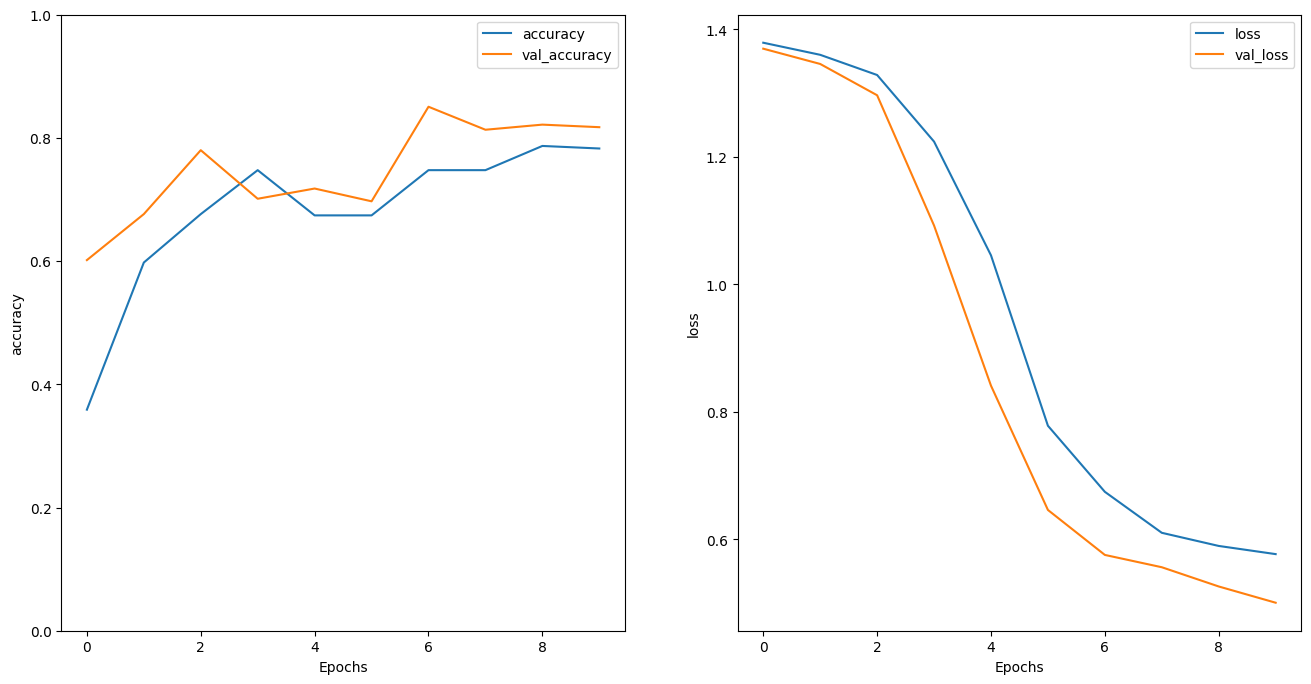

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0.0, 1.0)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#Question

## Q1

Change the rnn structure and make the accuracy better.

### Q1-1

Show your model summary.

In [68]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 128, #Chanhe it
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    # Now, try to design your RNN
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # complex nn
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)), # 64, change to 32 if complex nn used
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # complex nn
    tf.keras.layers.Dense(num_class, activation='softmax') # from_logits=False, SparseCategoricalCrossentropy
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


history = model.fit(train_dataset, epochs=15,
                    validation_data = val_dataset, # isn't it cheating?
                    )



Epoch 1/15
31/31 [==============================] - 22s 373ms/step - loss: 1.3680 - accuracy: 0.5274 - val_loss: 1.3434 - val_accuracy: 0.7676
Epoch 2/15
31/31 [==============================] - 7s 235ms/step - loss: 1.3072 - accuracy: 0.7156 - val_loss: 1.2311 - val_accuracy: 0.8050
Epoch 3/15
31/31 [==============================] - 8s 247ms/step - loss: 1.1130 - accuracy: 0.7198 - val_loss: 0.9815 - val_accuracy: 0.7303
Epoch 4/15
31/31 [==============================] - 7s 240ms/step - loss: 0.9009 - accuracy: 0.6629 - val_loss: 0.7463 - val_accuracy: 0.7884
Epoch 5/15
31/31 [==============================] - 6s 206ms/step - loss: 0.7497 - accuracy: 0.6980 - val_loss: 0.6111 - val_accuracy: 0.8050
Epoch 6/15
31/31 [==============================] - 7s 217ms/step - loss: 0.6542 - accuracy: 0.6805 - val_loss: 0.5510 - val_accuracy: 0.7925
Epoch 7/15
31/31 [==============================] - 7s 230ms/step - loss: 0.6047 - accuracy: 0.7104 - val_loss: 0.5616 - val_accuracy: 0.8091
Epoch

In [69]:
# use val_dataset as testing dataset
test_loss, test_acc = model.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 86ms/step - loss: 0.4137 - accuracy: 0.8257
Test Loss: 0.41365373134613037
Test Accuracy: 0.8257261514663696


In [64]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_14 (Embedding)    (None, None, 128)         15744     
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 4)               

### Q1-2

Show your confusion matrix.

In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix
# 進行預測
predictions = model.predict(val_dataset)
y_pred = np.argmax(predictions, axis=1)

# 取出真實標籤
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

8/8 [==============================] - 3s 113ms/step
Confusion Matrix:
[[ 8 14 16 20]
 [12 17 14 10]
 [12 17 18 15]
 [13 18 14 23]]


## Q2

Try to use one-hot encoding and a dense neural network to classify the same dataset.

###Q2-1

Show your model summary.

In [71]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(),  # Add this line to flatten the output
    tf.keras.layers.Dense(num_class, activation='softmax')
])

In [72]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [73]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, # isn't it cheating?
                    )

Epoch 1/10
31/31 [==============================] - 23s 362ms/step - loss: 1.3657 - accuracy: 0.5750 - val_loss: 1.3416 - val_accuracy: 0.6432
Epoch 2/10
31/31 [==============================] - 7s 221ms/step - loss: 1.3050 - accuracy: 0.6515 - val_loss: 1.2411 - val_accuracy: 0.6390
Epoch 3/10
31/31 [==============================] - 7s 201ms/step - loss: 1.0831 - accuracy: 0.5988 - val_loss: 0.8547 - val_accuracy: 0.7054
Epoch 4/10
31/31 [==============================] - 7s 230ms/step - loss: 0.7364 - accuracy: 0.6743 - val_loss: 0.6025 - val_accuracy: 0.7303
Epoch 5/10
31/31 [==============================] - 7s 228ms/step - loss: 0.6260 - accuracy: 0.7166 - val_loss: 0.5707 - val_accuracy: 0.7842
Epoch 6/10
31/31 [==============================] - 6s 207ms/step - loss: 0.6179 - accuracy: 0.7394 - val_loss: 0.5505 - val_accuracy: 0.7884
Epoch 7/10
31/31 [==============================] - 7s 211ms/step - loss: 0.6040 - accuracy: 0.7353 - val_loss: 0.5521 - val_accuracy: 0.8423
Epoch

In [74]:
# print Q2-1 model
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_17 (Embedding)    (None, None, 128)         15744     
                                                                 
 bidirectional_9 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 4)               

In [77]:
# use val_dataset as testing dataset
test_loss, test_acc = model.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 69ms/step - loss: 0.5069 - accuracy: 0.8506
Test Loss: 0.5068659782409668
Test Accuracy: 0.8506224155426025


###Q2-2

Show the confusion matrix of one-hot dense mdoel.


In [75]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 進行預測
predictions = model.predict(val_dataset)
y_pred = np.argmax(predictions, axis=1)

# 取出真實標籤
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

8/8 [==============================] - 3s 75ms/step
Confusion Matrix:
[[16 10 16 16]
 [12 16 15 10]
 [22 12 10 18]
 [13 11 21 23]]


##Q3



###Q3-1

Which model performs better? Why?

在給定的情況下，one-hot 模型的測試準確度（0.8506）確實優於原本的 RNN 模型（0.8257）。這顯示出在這個特定的問題上，one-hot 模型表現更好。這可能是由於其較簡單的模型結構和較少的參數量，使其能夠更好地適應訓練資料並獲得更好的泛化性能。

因此，根據給定的測試結果，在這個問題上，one-hot 模型表現更好。

###Q3-2

If you extend the input size of RNN, will the acc increase? Or there should be a sweet spot of the length?

增加 RNN 的輸入大小不一定會直接導致準確度的提高。RNN 模型的性能受到多個因素的影響，包括資料的特性、模型的架構、訓練方式等等。在某些情況下，增加輸入大小可能有助於模型更好地捕捉時間序列資料的特徵，從而提高準確度。然而，在其他情況下，增加輸入大小可能會導致模型過於複雜，出現過擬合的問題，從而降低準確度。

###Q3-3

If you use one-hot two-gram or one-hot three-gram, will the dense model become better?

使用 one-hot 編碼的二元組或三元組可能會提高密集模型的效果。這是因為二元組或三元組可以捕捉更多的詞彙關聯性和語境信息，從而提供更豐富的特徵表示。這樣的話，模型在預測時將能夠更好地理解詞彙之間的關係，從而提高分類的準確性。然而，這也可能增加模型的計算成本和記憶體需求。總體而言，將二元組或三元組的 one-hot 編碼用於密集模型可能會改善模型的性能。